# Notebook: B-spline-like bases for C2 cubics on the Powell-Sabin 12-split
This is a Jupyter notebook accompanying the paper [1], which introduces simplex spline bases on the space of $C^2$ cubics on the Powell-Sabin 12-split. Using functionality from the `SSplines` library, we symbolically and numerically verify many of the results stated and proved mathematically in the paper. In addition, we provide the code for generating the graphics in the paper.

[1] T. Lyche, G. Muntingh, _B-spline-like bases for $C^2$ cubics on the Powell-Sabin 12-split_, available at https://arxiv.org/abs/1901.06885.

## Importing libraries

In [2]:
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, transforms
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

from IPython.display import Latex

import numpy as np
import sympy as sp
X ,  Y     = sp.symbols('X Y')
a1, a2, a3 = sp.symbols('a1 a2 a3'); a3 =   - a1 - a2 # Directional coordinates
b1, b2, b3 = sp.symbols('b1 b2 b3'); b3 = 1 - b1 - b2 # Barycentric coordinates
c1, c2, c3 = sp.symbols('c1 c2 c3'); c3 = 1 - c1 - c2 # Barycentric coordinates

from fractions import Fraction
import math

import sys

my_path = '../'
sys.path.insert(0, my_path)

output_path = './figs/'
globs = globals()

import SSplines
from SSplines.helper_functions import simplex_spline_graphic_small, determine_sub_triangle, ps12_vertices

from SSplines.helper_functions import r1_single, r2_single, r3_single, \
                                      u1_single, u2_single, u3_single, barycentric_coordinates
from SSplines.constants import KNOT_MULTIPLICITIES, WEIGHTS, \
                                QI_POINTS_BARYCENTRIC_CUBIC, QI_INDICES_CUBIC
from SSplines.constants import PS12_DUAL_POINTS_BARYCENTRIC_COORDINATES as dp
from SSplines.constants import PS12_DUAL_POINTS_BARYCENTRIC_COORDINATES, KNOT_MULTIPLICITIES, WEIGHTS
from SSplines.constants import PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES, \
                                PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_QUADRATIC_ALTERNATIVE, \
                                PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_CUBIC_ALTERNATIVE

from SSplines.simplex_spline import SimplexSpline
from SSplines.spline_function import SplineFunction

from SSplines.symbolic import multinomial

from SSplines.dicts import KNOT_CONFIGURATION_TO_FACE_INDICES

from itertools import combinations    

#for mm in [[1,0,0,1,0,1], [2,0,0,1,0,1], [3,0,0,1,0,1], [4,0,0,1,0,1], [4,1,1,0,0,0], [3,2,1,0,0,0], [2,2,2,0,0,0]]:
#    simplex_spline_graphic_small(mm, filename = output_path + "SimplexSplineSmall" + "".join([str(expr) for expr in mm])+ ".pdf")

## Preparing the spline space

In [3]:
triangle = np.array([[0, 0],[1, 0],[0, 1]], dtype = np.int)
degree = 3

S = SSplines.SplineSpace(triangle, degree)
print(S)


Degree   : 3
Dimension: 16
Vertices : 
    v1: (0, 0)  
    v2: (1, 0)
    v3: (0, 1)
        


## Helper functions

In [6]:
def compositions(n,k):
    if n < 0 or k < 0:
        return
    elif k == 0:
        if n == 0:
            yield []
        return
    elif k == 1:
        yield [n]
        return
    else:
        for i in range(0,n+1):
            for comp in compositions(n-i,k-1):
                yield [i] + comp

def linear_combination(terms):
    """ For a list `terms` of pairs c (coefficient), mm (knot vector),
        return the corresponding linear combination. """
    expr = np.array(12*[Fraction(0,1)])
    for c, mm in terms:
        pp = SimplexSpline(triangle, mm).polynomial_pieces
        expr = [expr[i] + c*pp[i] for i in range(12)]
    
    return([expr1.expand() for expr1 in expr])

print("Example: Barycentric coordinates sum to 1 on each triangle:")
print(linear_combination([(1, [2,1,1]), (1, [1,2,1]), (1, [1,1,2])]))

print("Example: Equation (17) in the paper:")
print(not np.any(linear_combination([(-4,[2,2,2]), (1,[2,1,1,1,0,1]), (1,[1,1,2,0,1,1]), \
                                                   (1,[1,1,1,1,1,1]), (1,[1,2,1,1,1,0])])))

Example: Barycentric coordinates sum to 1 on each triangle:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Example: Equation (17) in the paper:
True


# Enumeration of simplex splines
To enumerate all possible simplex splines of a given degree and smoothness on the Powell-Sabin 12-split, we first introduce some helper functions.

In [7]:
def correct_lines(mm):
    """ Returns whether the knot vector mm only specifies the correct knot lines.
        This corresponds to Equation (20) in the [1]. """
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = mm
    return m1*m8 + m1*m9 + m8*m9 + m2*m7 + m2*m9 + m7*m9 + m3*m7 + m3*m8 + m7*m8 == 0

def is_smooth(mm, r):
    """ Returns whether the knot vector mm of a simplex spline has C^r
        smoothness on the 12-split."""
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = mm    
    d = sum(mm) - 3
    m = d + 1 - r
    
    for mm0 in [(m1,m5,m7,m10), (m2,m6,m8,m10), (m3,m4,m9,m10), (m4,m6,m7), (m4,m5,m8), (m5,m6,m9)]:
        if sum(mm0) > m and sum([m0 > 0 for m0 in mm0]) > 1: return False
        
    return True

def is_nondegenerate(mm):
    """ Return whether the knots with nonzero multiplicity in the knot vector mm are
        not collinear."""
    
    # Choose a triangle for which all vertices of the 12-split have integer coordinates.
    triangle = np.array([[0, 0],[12,0],[0, 12]], dtype = np.int)
    pp = SSplines.ps12_vertices(triangle)

    A = np.matrix([[1, pp[i][0],pp[i][1]]  for i in range(10) if mm[i] > 0], dtype = int)

    return np.linalg.matrix_rank(A) > 2

def reduces_to_B_spline(mm, r):
    """ Return whether mm reduces to a B-spline on the boundary, in the sense of (30) in [1]. """
    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = mm
    
    deg = sum(mm) - 3
    m   = sum(mm) - 1    
    
    if m1 + m2 + m4 < m and m2 + m3 + m5 < m and m1 + m3 + m6 < m:
        return True
    
    if m1 + m2 + m4 == m and m4 >= deg - r + 1: return False
    if m2 + m3 + m5 == m and m5 >= deg - r + 1: return False
    if m1 + m3 + m6 == m and m6 >= deg - r + 1: return False

    if m1 + m2 + m4 == m and m4 != deg - r and m1 >= 1 and m2 >= 1: return False
    if m2 + m3 + m5 == m and m5 != deg - r and m2 >= 1 and m3 >= 1: return False
    if m1 + m3 + m6 == m and m6 != deg - r and m1 >= 1 and m3 >= 1: return False

    return True

def viable_knotvectors(deg, r):
    """ Return the list of knot vectors of nondegenerate simplex splines on the
        Powell-Sabin 12-split of degree deg and smoothness r."""
    L_knots = []
    
    for mm in compositions(deg + 3, 10):
        if correct_lines(mm) and is_smooth(mm, r) and \
            is_nondegenerate(mm) and reduces_to_B_spline(mm, r):
            L_knots.append(mm)
    
    return L_knots

## Symbolic verification of Lemma 1 in [1] for $d=1,2,3$.
__Lemma 1 in [1].__
Suppose $Q[\boldsymbol{p}_1^{\mu_1}\cdots\boldsymbol{p}_{10}^{\mu_{10}}]$ is a $C^r$-smooth simplex spline of degree $d$ on the Powell-Sabin 12-split. If $d \leq 2r + 1$, then
$$ \mu_7 = \mu_8 = \mu_9 = 0.$$
If $d \leq \left\lceil\frac32 r\right\rceil$, then
$$ \mu_{10} = 0, $$
$$ \mu_1 + \mu_5,\, \mu_2 + \mu_6,\, \mu_3 + \mu_4,\, \mu_4 + \mu_6,\, \mu_4 + \mu_5,\, \mu_5 + \mu_6\leq d+1-r,$$
(whenever both multiplicities are nonzero),
$$ \mu_4 + \mu_5 + \mu_6 \leq \frac32 (d + 1 - r),$$
$$ \mu_1 + \mu_2 + \mu_3 \geq \frac12 (3r + 3 - d), $$

In [8]:
for deg in [1,2,3]:
    r = deg - 1
    L_knots = viable_knotvectors(deg, deg - 1)

    for mm in L_knots:
        m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = mm
        if m7 != 0 or m8 != 0 or m9 != 0:
            print("Error: Equation (23) does not hold!")
        if deg <= math.ceil(3*r/2):
            if m10 != 0:
                print("Error: Equation (24) does not hold!")
            m = deg + 1 - r
            if (m1 + m5 > m and m1 != 0 and m5 != 0) or \
                (m2 + m6 > m and m2 != 0 and m6 != 0) or \
                (m3 + m4 > m and m3 != 0 and m4 != 0) or \
                (m4 + m6 > m and m4 != 0 and m6 != 0) or \
                (m4 + m5 > m and m4 != 0 and m5 != 0) or \
                (m5 + m6 > m and m5 != 0 and m6 != 0):
                print("Error: Equation (25) does not hold!")
                print(mm)
            if m4 + m5 + m6 > 3*m/2:
                print("Error: Equation (26) does not hold!")
            if m1 + m2 + m3 < (3*r + 3 - deg)/2: 
                print("Error: Equation (27) does not hold!")                

## Symbolic verification of Theorem 2 and Table 1 in [1]
For $d=1,2,3$, we next present an exhaustive list of the $C^2$ cubic simplex splines on the Powell-Sabin 12-split that reduce to either zero or a B-spline on the boundary.

In [9]:
for deg in [1,2,3]:
    L_knots = viable_knotvectors(deg, deg - 1)

    print("\nThe C^"+str(deg-1)+"-smooth simplex splines of degree " + str(deg) + " are those with the knot vectors:")
    for mm in L_knots:
        print(mm)


The C^0-smooth simplex splines of degree 1 are those with the knot vectors:
[0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
[0, 0, 1, 0, 1, 1, 0, 0, 0, 1]
[0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 2, 0, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 1, 1, 0, 0, 0, 0, 1]
[0, 1, 0, 1, 1, 1, 0, 0, 0, 0]
[0, 1, 1, 0, 1, 0, 0, 0, 0, 1]
[0, 1, 1, 0, 1, 1, 0, 0, 0, 0]
[0, 1, 1, 1, 0, 1, 0, 0, 0, 0]
[0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 2, 0, 1, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
[1, 0, 0, 1, 1, 1, 0, 0, 0, 0]
[1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
[1, 0, 1, 0, 1, 1, 0, 0, 0, 0]
[1, 0, 1, 1, 0, 1, 0, 0, 0, 0]
[1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[1, 1, 0, 1, 0, 0, 0, 0, 0, 1]
[1, 1, 0, 1, 0, 1, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 1]
[1, 1, 1, 0, 0, 1, 0, 0, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 1, 0, 1, 0, 0, 0, 0]

The C^1-smooth simplex splines of degree 2 are those with the knot vectors:
[0, 0, 3, 0, 1, 1, 0, 0, 0, 0]
[0, 1, 1,

# Recurrence relation for S-bases on the 12-split
__Theorem 3 in [1].__ We have 
$$
\boldsymbol{s}_d^T = \boldsymbol{s}_{d-1}^T \boldsymbol{R}_d, \quad d=1,2,3,
$$
where
$$
\boldsymbol{R}_1 =
\begin{bmatrix}
\gamma_1& 0& 0& 0& 0&2\beta_{3,2} & 4 \beta_2& 0& 0& 0\\
 \gamma_1& 0& 0& 2\beta_{2,3}& 0& 0& 4 \beta_3& 0& 0& 0\\
 0& \gamma_2& 0&2\beta_{1,3}& 0& 0& 0& 4 \beta_3& 0& 0\\
 0& \gamma_2& 0& 0& 2\beta_{3,1}& 0& 0& 4 \beta_1& 0& 0\\
 0& 0&\gamma_3& 0&2\beta_{2,1}& 0& 0& 0& 4 \beta_1& 0\\
 0& 0& \gamma_3& 0& 0& 2\beta_{1,2}& 0& 0& 4 \beta_2& 0\\
 0& 0& 0& 0& 0& 2 \beta_{3,2}& 4 \beta_{1,3}& 0& 0& -3\gamma_1\\
 0& 0& 0& 2\beta_{2,3} & 0& 0& 4\beta_{1,2}& 0& 0& -3\gamma_1\\
 0& 0& 0& 2\beta_{1,3} & 0& 0& 0& 4\beta_{2,1}& 0& -3\gamma_2\\
 0& 0& 0& 0& 2\beta_{3,1}& 0& 0& 4\beta_{2,3} & 0& -3\gamma_2\\
 0& 0& 0& 0& 2\beta_{2,1} & 0& 0& 0& 4\beta_{3,2} & -3\gamma_3\\
 0& 0& 0& 0& 0& 2\beta_{1,2} & 0& 0& 4\beta_{3,1}& -3\gamma_3
\end{bmatrix} \in\mathbb{P}_1^{12,10},
$$

$$
\boldsymbol{R}_2 =
\begin{bmatrix}
 \gamma_1 & 2 \beta_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &
   0 & 2\beta_3 \\
 0 & 0 & 0 & 2 \beta_1 & \gamma_2 & 2\beta_3 & 0 & 0 & 0 & 0
   & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2\beta_2 & \gamma_3 & 2 \beta_1
   & 0 & 0 \\
 0 & \beta_{1,3} & 3\beta_3 & \beta_{2,3} & 0 & 0 & 0 & 0
   & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & \beta_{2,1} & 3\beta_1 & \beta_{3,1} &
   0& 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \beta_{3,2} & 3
  \beta_2 & \beta_{1,2} \\
 0 & \frac{\beta_{1,3}}{2} & \frac{3\beta_2}{2} & 0 & 0 &
   0 & 0 & 0 & 0 & 0 & \frac{3\beta_3}{2} &
   \frac{\beta_{1,2}}{2} \\
 0 & 0 & \frac{3\beta_1}{2} & \frac{\beta_{2,3}}{2} & 0 &
   \frac{\beta_{2,1}}{2} & \frac{3\beta_3}{2} & 0 & 0 & 0
   & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & \frac{3\beta_2}{2} &
   \frac{\beta_{3,1}}{2} & 0 & \frac{\beta_{3,2}}{2}
   & \frac{3\beta_1}{2} & 0 \\
 0 & 0 & -\gamma_3 & 0 & 0 & 0 & -\gamma_1 & 0 &
   0 & 0 & -\gamma_2 & 0
\end{bmatrix} \in \mathbb{P}_1^{10,12}
$$

$$
\boldsymbol{R}_3 = 
\begin{bmatrix}
\gamma_1 & 2 \beta _2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &
   0 & 2 \beta _3 & 0 & 0 & 0 & 0 \\
 0 & \beta _{1,3} & \beta _2 & 0 & 0 & 0 & 0 & 0 & 0 & 0
   & 0 & 0 & 2 \beta _3 & 0 & 0 & 0 \\
 0 & 0 & \frac{\sigma_{1,2}}{3} & 0 & 0 &
   0 & \frac{\beta _3}{3} & 0 & 0 & 0 & \frac{\beta _3}{3} &
   0 & \frac{2 \beta _1}{3} & \frac{2 \beta _2}{3} & 0 &
   \frac{\beta _3}{3} \\
 0 & 0 & \beta _1 & \beta _{2,3} & 0 & 0 & 0 & 0 & 0 & 0
   & 0 & 0 & 0 & 2 \beta _3 & 0 & 0 \\
 0 & 0 & 0 & 2 \beta _1 & \gamma_2 & 2 \beta _3 & 0 & 0 &
   0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & \beta _{2,1}& \beta _3 & 0 & 0 & 0
   & 0 & 0 & 0 & 2 \beta _1 & 0 & 0 \\
 0 & 0 & \frac{\beta _1}{3} & 0 & 0 & 0 & \frac{
   \sigma_{2,3}}{3} & 0 & 0 & 0 & \frac{\beta
   _1}{3} & 0 & 0 & \frac{2 \beta _2}{3} & \frac{2 \beta
   _3}{3} & \frac{\beta _1}{3} \\
 0 & 0 & 0 & 0 & 0 & 0 & \beta _2 & \beta _{3,1} & 0 & 0
   & 0 & 0 & 0 & 0 & 2 \beta _1 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 \beta _2 & \gamma_3 & 2
   \beta _1 & 0 & 0 & 0 & 0 & 0 & 0 \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \beta _{3,2} &
   \beta _1 & 0 & 0 & 0 & 2 \beta _2 & 0 \\
 0 & 0 & \frac{\beta _2}{3} & 0 & 0 & 0 & \frac{\beta _2}{3}
   & 0 & 0 & 0 & \frac{\sigma_{1,3}}{3}&
   0 & \frac{2 \beta _1}{3} & 0 & \frac{2 \beta _3}{3} &
   \frac{\beta _2}{3} \\
 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \beta _3 & \beta
   _{1,2} & 2 \beta _2 & 0 & 0 & 0
\end{bmatrix}\in \mathbb{P}_1^{12,16}
$$
Moreover, $\boldsymbol{R}_d(i,j) S_{i,d-1}(\boldsymbol{x})\ge 0$ for all $i,j$ and $\boldsymbol{x}\in\Delta$.


In [10]:
p1, p2, p3 = triangle

s0 = [(WEIGHTS[0][i], SimplexSpline(triangle,KNOT_MULTIPLICITIES[0][i]).polynomial_pieces) for i in range(12)]
s1 = [(WEIGHTS[1][i], SimplexSpline(triangle,KNOT_MULTIPLICITIES[1][i]).polynomial_pieces) for i in range(10)]
s2 = [(WEIGHTS[2][i], SimplexSpline(triangle,KNOT_MULTIPLICITIES[2][i]).polynomial_pieces) for i in range(12)]
s3 = [(WEIGHTS[3][i], SimplexSpline(triangle,KNOT_MULTIPLICITIES[3][i]).polynomial_pieces) for i in range(16)]

s0, s1, s2, s3 = [[[w*p.subs({X: b1*p1[0] + b2*p2[0] + b3*p3[0], Y: b1*p1[1] + b2*p2[1] + b3*p3[1]}) \
                for p in pp] for w, pp in s] for s in [s0,s1,s2,s3]]

s0 = np.transpose(np.matrix(np.array(s0, dtype = np.object)))
s1 = np.transpose(np.matrix(np.array(s1, dtype = np.object)))
s2 = np.transpose(np.matrix(np.array(s2, dtype = np.object)))
s3 = np.transpose(np.matrix(np.array(s3, dtype = np.object)))

bb = np.array([b1,b2,b3], dtype = np.object)
R1 = np.matrix(r1_single(bb, exact = True))
R2 = np.matrix(r2_single(bb, exact = True))
R3 = np.matrix(r3_single(bb, exact = True))

vexpand = np.vectorize(lambda expr: expr.expand())
for d in [1,2,3]:
    M = globs["s"+str(d)] - globs["s"+str(d-1)]*globs["R"+str(d)]
    print("One has s_" + str(d) + " = s_" + str(d-1) + " R_" + str(d) + ":", not np.any(vexpand(M)))

One has s_1 = s_0 R_1: True
One has s_2 = s_1 R_2: True
One has s_3 = s_2 R_3: True


## Alternative quadratic S-basis
We verify Equation (36) in Remark 4 in [1].

In [11]:
B0 = [SimplexSpline(triangle, mm).polynomial_pieces \
      for mm in [[1,1,1,1,0,1], [1,1,1,1,1,0], [1,1,1,0,1,1]]]

B1 = [SimplexSpline(triangle, mm).polynomial_pieces \
      for mm in [[1,1,0,1,1,1], [0,1,1,1,1,1], [1,0,1,1,1,1]]]

B0, B1 = [np.matrix(np.array(Bi, dtype = np.object)) for Bi in [B0, B1]]

T2 = np.matrix([[Fraction(1,2), 0, Fraction(1,2)], \
                [Fraction(1,2), Fraction(1,2), 0], \
                [0, Fraction(1,2), Fraction(1,2)]], dtype = np.object) 

print("We verify Equation (36) in Remark 4 in [1]:", not np.any(vexpand(T2*B1 - B0)))

We verify Equation (36) in Remark 4 in [1]: True


## Alternative cubic S-basis
We verify Equation (38) in Remark 6 in [1].

In [12]:
B0 = [w*np.matrix(SimplexSpline(triangle, mm).polynomial_pieces, dtype = np.object) \
      for w, mm in [(3, [2,1,1,1,0,1]), (3, [1,2,1,1,1,0]), (3, [1,1,2,0,1,1]), (4, [2,2,2,0,0,0])]]

B1 = [w*np.matrix(SimplexSpline(triangle, mm).polynomial_pieces, dtype = np.object) \
      for w, mm in [(1, [2,1,1,1,0,1]), (1, [1,2,1,1,1,0]), (1, [1,1,2,0,1,1]), (1, [1,1,1,1,1,1])]]

B0, B1 = [np.matrix(np.array(Bi, dtype = np.object)) for Bi in [B0, B1]]

T2 = np.matrix([[3,0,0,0],\
                [0,3,0,0],\
                [0,0,3,0],\
                [1,1,1,1]], dtype = np.object) 

print("We verify Equation (38) in Remark 6 in [1]:", not np.any(vexpand(T2*B1 - B0)))

We verify Equation (38) in Remark 6 in [1]: True


## Derivatives and blossom properties
__Lemma 3 in [1].__ For any $\boldsymbol{x},\boldsymbol{y},\boldsymbol{u}\in\mathbb{R}^2$,
$$  \boldsymbol{R}_i(\boldsymbol{x})\boldsymbol{R}_{i+1}(\boldsymbol{y}) = \boldsymbol{R}_i(\boldsymbol{y})\boldsymbol{R}_{i+1}(\boldsymbol{x}),\qquad i=1,2,$$
$$ D_\boldsymbol{u} \boldsymbol{R}_i)\boldsymbol{R}_{i+1}(\boldsymbol{x}) = \boldsymbol{R}_i(\boldsymbol{x})(D_\boldsymbol{u}\boldsymbol{R}_{i+1}),\qquad i=1,2.$$


In [13]:
R1x = np.matrix(r1_single( np.array([b1,b2,b3], dtype = object), exact = True))
R2x = np.matrix(r2_single( np.array([b1,b2,b3], dtype = object), exact = True))
R3x = np.matrix(r3_single( np.array([b1,b2,b3], dtype = object), exact = True))

R1y = np.matrix(r1_single(np.array([c1,c2,c3], dtype = object), exact = True))
R2y = np.matrix(r2_single(np.array([c1,c2,c3], dtype = object), exact = True))
R3y = np.matrix(r3_single(np.array([c1,c2,c3], dtype = object), exact = True))

R12 = R1x*R2y - R1y*R2x
R23 = R2x*R3y - R2y*R3x
print("We verify Equation (46) in [1]:", not np.any(vexpand(R12)), not np.any(vexpand(R23)))

U1 = np.matrix(r1_single(np.array([c1,c2,c3], dtype = object), exact = True))
U2 = np.matrix(r2_single(np.array([c1,c2,c3], dtype = object), exact = True))
U3 = np.matrix(r3_single(np.array([c1,c2,c3], dtype = object), exact = True))

U12 = U1*R2x - R1x*U2
U23 = U2*R3x - R2x*U3
print("We verify Equation (47) in [1]:", not np.any(vexpand(U12)), not np.any(vexpand(U23)))

We verify Equation (46) in [1]: True True
We verify Equation (47) in [1]: True True


## Marsden identity
We state and verify the barycentric form of the Marsden identity.

__Corollary 4__ (Barycentric Marsden identity). 
Let $\beta_j = \beta_j(\boldsymbol{x})$, $j = 1,2,3$, be the barycentric coordinates of $\boldsymbol{x}\in \mathbb{R}^2$ with respect to $\Delta = [\boldsymbol{p}_1, \boldsymbol{p}_2, \boldsymbol{p}_3]$. Then
$$ (\beta_1c_1 + \beta_2c_2 + \beta_3c_3)^d = \sum_{j=1}^{n_d} S_{j,d}(\beta_1\boldsymbol{p}_1 + \beta_2\boldsymbol{p}_2 + \beta_3 \boldsymbol{p}_3) \Psi_j(c_1,c_2,c_3), $$
where $\boldsymbol{x}\in \Delta$, $c_1,c_2,c_3\in \mathbb{R}$, and, for $j = 1,\ldots, n_d$, 
$$ \Psi_j(c_1, c_2, c_3) = \prod_{k = 1}^d \big( \beta_1(\boldsymbol{p}_{j,d,k})c_1 + \beta_2(\boldsymbol{p}_{j,d,k})c_2 + \beta_3(\boldsymbol{p}_{j,d,k})c_3 \big).$$


In [14]:
b1, b2, b3 = sp.symbols('b1 b2 b3'); # Barycentric coordinates
c1, c2, c3 = sp.symbols('c1 c2 c3'); # Barycentric coordinates
c4, c5, c6, c10 = (c1 + c2)/2, (c2 + c3)/2, (c1 + c3)/2, (c1 + c2 + c3)/3

nd = [12,10,12,16]
for d in [1,2,3]:
    sd = [(WEIGHTS[d][i], SimplexSpline(triangle,KNOT_MULTIPLICITIES[d][i]).polynomial_pieces) for i in range(nd[d])]
    sd = [[w*p.subs({X: b1*p1[0] + b2*p2[0] + (1-b1-b2)*p3[0], Y: b1*p1[1] + b2*p2[1] + (1-b1-b2)*p3[1]}) \
                    for p in pp] for w, pp in sd]
    sd = np.transpose(np.matrix(np.array(sd, dtype = np.object)))

    dual_polys = np.matrix([np.prod(np.matrix(dp[d-1][i])*np.matrix([[c1],[c2],[c3]])) \
                     for i in range(nd[d])], dtype = np.object).transpose()

    expr = vexpand(sd*dual_polys - np.matrix(12*[(b1*c1 + b2*c2 + (1-b1-b2)*c3)**d]).transpose())
    print("\nMarsden identity for d = " + str(d) + ":", not np.any(expr))
    print((b1*c1 + b2*c2 + b3*c3)**d, "=")
    for i in range(nd[d]):
        w = str(WEIGHTS[d][i]); w = (3 - len(w))*" " + w
        print("+ " + w + " * Q" + str(KNOT_MULTIPLICITIES[d][i])+" *",dual_polys[i][0,0])


Marsden identity for d = 1: True
b1*c1 + b2*c2 + b3*c3 =
+ 1/4 * Q[2, 0, 0, 1, 0, 1, 0, 0, 0, 0] * c1
+ 1/4 * Q[0, 2, 0, 1, 1, 0, 0, 0, 0, 0] * c2
+ 1/4 * Q[0, 0, 2, 0, 1, 1, 0, 0, 0, 0] * c3
+ 1/3 * Q[1, 1, 0, 1, 0, 0, 0, 0, 0, 1] * c1/2 + c2/2
+ 1/3 * Q[0, 1, 1, 0, 1, 0, 0, 0, 0, 1] * c2/2 + c3/2
+ 1/3 * Q[1, 0, 1, 0, 0, 1, 0, 0, 0, 1] * c1/2 + c3/2
+ 1/3 * Q[1, 0, 0, 1, 0, 1, 0, 0, 0, 1] * c1/2 + c2/4 + c3/4
+ 1/3 * Q[0, 1, 0, 1, 1, 0, 0, 0, 0, 1] * c1/4 + c2/2 + c3/4
+ 1/3 * Q[0, 0, 1, 0, 1, 1, 0, 0, 0, 1] * c1/4 + c2/4 + c3/2
+ 1/4 * Q[0, 0, 0, 1, 1, 1, 0, 0, 0, 1] * c1/3 + c2/3 + c3/3

Marsden identity for d = 2: True
(b1*c1 + b2*c2 + b3*c3)**2 =
+ 1/4 * Q[3, 0, 0, 1, 0, 1, 0, 0, 0, 0] * c1**2
+ 1/2 * Q[2, 1, 0, 1, 0, 1, 0, 0, 0, 0] * c1*(c1/2 + c2/2)
+ 3/4 * Q[1, 1, 0, 1, 1, 1, 0, 0, 0, 0] * (c1/2 + c2/2)*(c1/3 + c2/3 + c3/3)
+ 1/2 * Q[1, 2, 0, 1, 1, 0, 0, 0, 0, 0] * c2*(c1/2 + c2/2)
+ 1/4 * Q[0, 3, 0, 1, 1, 0, 0, 0, 0, 0] * c2**2
+ 1/2 * Q[0, 2, 1, 1, 1, 0, 0, 0, 0, 0] * c2*(c

## Quasi-interpolants
As in [1], for $d = 1,2,3$ and each basis $\boldsymbol{s}_d$ with dual points $\boldsymbol{p}_{j,d,k}$ coming from the Marsden identity, consider the quasi-interpolant
$$ Q_d: C^0(\Delta)\longrightarrow \mathcal{S}_d(\Delta_{\mathrm{PS12}}),\qquad Q_d(f) = \sum_{j=1}^{n_d} L_{j,d}(f) S_{j,d}, $$
where the functionals $L_{j,d}: C^0(\Delta)\longrightarrow \mathbb{R}$ are given by
$$ L_{j,d}(f) = \sum_{m = 1}^d \frac{m^d}{d!} (-1)^{d-m} \sum_{1\leq k_1 < \cdots < k_m\leq d} f\left( \frac{\boldsymbol{p}_{j,d,k_1} + \cdots + \boldsymbol{p}_{j,d,k_m}}{m} \right). $$

The quasi-interpolant $Q_d$ is bounded independently of the geometry of $\Delta$, since, using that $\boldsymbol{s}_d$ forms a partition of unity,
$$ \|Q_d(F)\|_{L_\infty(\Delta)} \leq \max_i |l_{i,d}(F)|
\leq C_d \|F\|_{L_\infty(\Delta)},\quad C_d = \sum_{m=1}^d \frac{m^d}{d!}{d\choose m}.
$$
In particular, $[C_1, C_2, C_3] = [1, 3, 9]$. Therefore, by a standard argument, $Q_d$ is a quasi-interpolant that approximates locally with order 4 smooth functions whose first four derivatives are in $L_\infty(\Delta)$.

In [15]:
for d in [1,2,3]:
    print(sum([m**d/(math.factorial(d-m) * math.factorial(m)) for m in range(1,d+1)]))

1.0
3.0
9.0


## Polynomial reproduction
We verify using exact arithmetic that the quasi-interpolant $Q_3$ reproduces polynomials (as was previously established for $Q_1$ and $Q_2$).

In [16]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = SSplines.ps12_vertices(triangle)

for d in range(1, 3+1):
    dim = len(KNOT_MULTIPLICITIES[d])
    combi = list(compositions(d,3))

    # First loop over the Bernstein polynomials
    for l in range(len(combi)):
        i1, i2, i3 = combi[l]
        s = SimplexSpline(triangle, [i1+1, i2+1, i3+1])

        # Next loop over the S-bases functions    
        Q = 0*np.array(SimplexSpline(triangle, [1, 1, 1]).polynomial_pieces)    
        for j in range(dim):
            dp = PS12_DUAL_POINTS_BARYCENTRIC_COORDINATES[d-1][j]
            L_jd = Fraction(0,1)
            for m in range(1,d+1):
                factor = WEIGHTS[d][j] * (-1)**(d-m) * m**d / np.math.factorial(d)
                for tup in combinations(range(d),m):
                    p = np.dot( sum([dp[tup[i]-1] for i in range(len(list(tup)))])/m, np.array([p1,p2,p3]))
                    b1, b2, b3 = sum([dp[tup[i]-1] for i in range(len(list(tup)))])/m

                    L_jd += factor * multinomial(i1, i2, i3) * b1**i1 * b2**i2 * b3**i3

            Q += L_jd * np.array(SimplexSpline(triangle, KNOT_MULTIPLICITIES[d][j]).polynomial_pieces)

        err = [poly.expand() for poly in Q - s.polynomial_pieces]
        print("Q_3(B_"+str(i1)+str(i2)+str(i3)+") = B_"+str(i1)+str(i2)+str(i3) + ":", not np.any(err))
    print()

Q_3(B_001) = B_001: True
Q_3(B_010) = B_010: True
Q_3(B_100) = B_100: True

Q_3(B_002) = B_002: True
Q_3(B_011) = B_011: True
Q_3(B_020) = B_020: True
Q_3(B_101) = B_101: True
Q_3(B_110) = B_110: True
Q_3(B_200) = B_200: True

Q_3(B_003) = B_003: True
Q_3(B_012) = B_012: True
Q_3(B_021) = B_021: True
Q_3(B_030) = B_030: True
Q_3(B_102) = B_102: True
Q_3(B_111) = B_111: True
Q_3(B_120) = B_120: True
Q_3(B_201) = B_201: True
Q_3(B_210) = B_210: True
Q_3(B_300) = B_300: True



We verify using exact arithmetic that the Marsden identity expresses polynomials as linear combinations of the S-basis functions as derived in the paper. For this, we verify the expressions for the Bernstein polynomials
$$B^3_{300} = Q[\boldsymbol{p}_1^4 \boldsymbol{p}_2   \boldsymbol{p}_3  ],\quad
  B^3_{210} = Q[\boldsymbol{p}_1^3 \boldsymbol{p}_2^2 \boldsymbol{p}_3  ],\quad
  B^3_{111} = Q[\boldsymbol{p}_1^2 \boldsymbol{p}_2^2 \boldsymbol{p}_3^2]$$
derived in the paper from the barycentric Marsden identity. Expressions for the remaining Bernstein polynomials follow by the symmetry. These expressions have also been derived directly applying knot insertion.

In [17]:
print("Equation (61) in [1] holds:", not np.any(\
    linear_combination([(           -1, [4,1,1,0,0,0]),
                        (Fraction(1,4), [4,0,0,1,0,1]), (Fraction(1,4), [3,1,0,1,0,1]),
                        (Fraction(1,4), [3,0,1,1,0,1]), (Fraction(1,4), [2,1,1,1,0,1])])))

print("Equation (62) in [1] holds:", not np.any(\
    linear_combination([(           -1, [3,2,1,0,0,0]), (Fraction(1,4), [3,1,0,1,0,1]),
                        (Fraction(1,2), [2,2,1,1,0,0]), (Fraction(1,4), [2,1,1,1,0,1])])))

print("Equation (63) in [1] holds:", not np.any(\
    linear_combination([(           -1, [2,2,2,0,0,0]),
                        (Fraction(1,4), [2,1,1,1,0,1]), (Fraction(1,4), [1,2,1,1,1,0]),
                        (Fraction(1,4), [1,1,2,0,1,1]), (Fraction(1,4), [1,1,1,1,1,1])])))

Equation (61) in [1] holds: True
Equation (62) in [1] holds: True
Equation (63) in [1] holds: True


Next we show using exact arithmetic that the quasi-interpolant $Q_3$ expresses the Bernstein polynomials $B^3_{300}, B^3_{210}, B^3_{111}$ as the same linear combinations (verified above) provided by the Marsden identity. In addition, we check that $Q_3$ does not reproduce $Q[\boldsymbol{p}_1^4 \boldsymbol{p}_4 \boldsymbol{p}_6]$, as shown in Remark 12 in [1].

In [18]:
L = 3*[Fraction(1,6)] + 3*[-Fraction(4,3)] + [Fraction(9,2)]
for mm in [[4,1,1,0,0,0,0,0,0,0], [3,2,1,0,0,0,0,0,0,0], [2,2,2,0,0,0,0,0,0,0], [4,0,0,1,0,1,0,0,0,0]]:
    print("Q_3( Q", str(mm), ") = ")
    S0 = SimplexSpline(triangle, mm)
    for i in range(16):
        expr = Fraction(0,1)
        for j in range(7):
            b1, b2, b3 = QI_POINTS_BARYCENTRIC_CUBIC[QI_INDICES_CUBIC[i][j]-1]
            p = np.dot(np.array([[b1, b2, b3]]), triangle)
            expr += L[j]*S0(p, exact = True)[0]

        if expr != 0:
            print("     Q", KNOT_MULTIPLICITIES[3][i], "*", WEIGHTS[3][i], "*", expr, "+")

    print()

Q_3( Q [4, 1, 1, 0, 0, 0, 0, 0, 0, 0] ) = 
     Q [4, 0, 0, 1, 0, 1, 0, 0, 0, 0] * 1/4 * 1 +
     Q [3, 1, 0, 1, 0, 1, 0, 0, 0, 0] * 1/2 * 1/2 +
     Q [3, 0, 1, 1, 0, 1, 0, 0, 0, 0] * 1/2 * 1/2 +
     Q [2, 1, 1, 1, 0, 1, 0, 0, 0, 0] * 1 * 1/4 +

Q_3( Q [3, 2, 1, 0, 0, 0, 0, 0, 0, 0] ) = 
     Q [3, 1, 0, 1, 0, 1, 0, 0, 0, 0] * 1/2 * 1/2 +
     Q [2, 2, 1, 1, 0, 0, 0, 0, 0, 0] * 1 * 1/2 +
     Q [2, 1, 1, 1, 0, 1, 0, 0, 0, 0] * 1 * 1/4 +

Q_3( Q [2, 2, 2, 0, 0, 0, 0, 0, 0, 0] ) = 
     Q [2, 1, 1, 1, 0, 1, 0, 0, 0, 0] * 1 * 1/4 +
     Q [1, 2, 1, 1, 1, 0, 0, 0, 0, 0] * 1 * 1/4 +
     Q [1, 1, 2, 0, 1, 1, 0, 0, 0, 0] * 1 * 1/4 +
     Q [1, 1, 1, 1, 1, 1, 0, 0, 0, 0] * 1/4 * 1 +

Q_3( Q [4, 0, 0, 1, 0, 1, 0, 0, 0, 0] ) = 
     Q [4, 0, 0, 1, 0, 1, 0, 0, 0, 0] * 1/4 * 4 +
     Q [1, 1, 1, 1, 1, 1, 0, 0, 0, 0] * 1/4 * 2/3 +



## Table 5 in [1]
We generate the values of the Bernstein polynomials $B^3_{300}, B^3_{210}, B^3_{111}$ at the dual point averages $l_1, \ldots, l_{25}$.

In [19]:
v1, v2, v3 = triangle

lines = ["\\begin{array}{ccccccccccccc}"]
for ii in [range(13), range(13, 25)]:
    lines.append("\hline")
    lines.append("           & " + " & ".join(["\\boldsymbol{l}_{" + str(i+1)+"}" for i in ii]) + "\\\\")

    for mm in [[4,1,1,0,0,0], [3,2,1,0,0,0], [2,2,2,0,0,0]]:
        S0 = SimplexSpline(triangle, mm)

        s  = "Q[" + "".join([str(m) for m in mm]) + "]"
        for i in ii:
            bb = QI_POINTS_BARYCENTRIC_CUBIC[i]
            vi = bb[0]*v1 + bb[1]*v2 + bb[2]*v3

            #print("l_"+str(i+1) + (2-len(str(i+1)))*" ", ":", S0([vi], exact = True)[0])
            val = S0([vi], exact = True)[0]
            num, den = val.as_numer_denom()
            if den == 1:
                s += " & " + str(val)
            else:
                s += " & " + "\\frac{"+str(num)+"}{"+str(den)+"}"

        lines.append(s + "\\\\")
        
lines.append("\\hline")
lines.append("\\end{array}")

Latex("\n".join(lines))

<IPython.core.display.Latex object>

# Condition numbers
Consider the _collocation matrix_ $\boldsymbol{M} := [S_j(\xi_i)]_{i,j=1}^{n_d}$. An exact computation, verified using the simplex\_spline functionality, yields the $L_\infty$ condition numbers for the collocation matrices $\boldsymbol{M}_1, \boldsymbol{M}_2,\tilde{\boldsymbol{M}}_2, \boldsymbol{M}_3, \tilde{\boldsymbol{M}}_3$ corresponding to the bases $\boldsymbol{s}_1, \boldsymbol{s}_2,\tilde{\boldsymbol{s}}_2, \boldsymbol{s}_3, \tilde{\boldsymbol{s}}_3$ and domain points ${\boldsymbol{\xi}}_1, {\boldsymbol{\xi}}_2,\tilde{{\boldsymbol{\xi}}}_2, {\boldsymbol{\xi}}_3, \tilde{{\boldsymbol{\xi}}}_3$.

In [4]:
from SSplines.constants import WEIGHTS_LINEAR as ww1
from SSplines.constants import WEIGHTS_QUADRATIC as ww2
from SSplines.constants import WEIGHTS_QUADRATIC_ALTERNATIVE as ww2_alt
from SSplines.constants import WEIGHTS_CUBIC as ww3
from SSplines.constants import WEIGHTS_CUBIC_ALTERNATIVE as ww3_alt

from SSplines.constants import KNOT_MULTIPLICITIES_LINEAR as mm1
from SSplines.constants import KNOT_MULTIPLICITIES_QUADRATIC as mm2
from SSplines.constants import KNOT_MULTIPLICITIES_QUADRATIC_ALTERNATIVE as mm2_alt
from SSplines.constants import KNOT_MULTIPLICITIES_CUBIC as mm3
from SSplines.constants import KNOT_MULTIPLICITIES_CUBIC_ALTERNATIVE as mm3_alt

from SSplines.constants import PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_LINEAR as dd1
from SSplines.constants import PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_QUADRATIC as dd2
from SSplines.constants import PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_QUADRATIC_ALTERNATIVE as dd2_alt
from SSplines.constants import PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_CUBIC as dd3
from SSplines.constants import PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_CUBIC_ALTERNATIVE as dd3_alt

for d, nd, ww, mm, dd, is_alternative in [\
                        (1, 10, ww1, mm1, dd1, False),\
                        (2, 12, ww2, mm2, dd2, False), (2, 12, ww2_alt, mm2_alt, dd2_alt, True),\
                        (3, 16, ww3, mm3, dd3, False), (3, 16, ww3_alt, mm3_alt, dd3_alt, True)]:
    print("The basis " + is_alternative*"tilde" +  "{s_" + str(d) + "} :")

    M = [[ww[i]*SimplexSpline(triangle, mm[i])([dd[j]], exact =  True, barycentric = True)[0] for i in range(nd)] for j in range(nd)]

    M = np.array(M)
    Minv = np.matrix(np.array(sp.Matrix(M).inv()))
    Minvinf = np.linalg.norm(np.matrix(Minv), np.inf)
    print("||M   ||_inf =", np.linalg.norm(np.matrix(M)   , np.inf))
    print("||M^-1||_inf =", Minvinf, "~", float(Minvinf))
    print()

The basis {s_1} :
||M   ||_inf = 1
||M^-1||_inf = 1 ~ 1.0

The basis {s_2} :
||M   ||_inf = 1
||M^-1||_inf = 28/9 ~ 3.111111111111111

The basis tilde{s_2} :
||M   ||_inf = 1
||M^-1||_inf = 295/9 ~ 32.77777777777778

The basis {s_3} :
||M   ||_inf = 1
||M^-1||_inf = 415/8 ~ 51.875

The basis tilde{s_3} :
||M   ||_inf = 1
||M^-1||_inf = 1297/17 ~ 76.29411764705883



# Smoothness conditions
Let $\Delta := [\boldsymbol{p}_1,\boldsymbol{p}_2,\boldsymbol{p}_3]$ and $\hat{\Delta} := [\boldsymbol{p}_1, \boldsymbol{p}_2, \hat{\boldsymbol{p}}_3]$ be triangles sharing the edge $e := [\boldsymbol{p}_1, \boldsymbol{p}_2]$ and with 12-splits $\Delta_{12}$ and $\hat{\Delta}_{12}$. On these triangles we consider the spline spaces $\mathcal{S}_3(\Delta_{12})$ and $\mathcal{S}_3(\hat{\Delta}_{12})$ with bases $\boldsymbol{s}_3 = [S_{i,3}]_i$ and $\hat{\boldsymbol{s}}_3 = [\hat{S}_{i,3}]_i$. Here $\hat{\boldsymbol{s}}_3$ is the pull-back of $\boldsymbol{s}_3$ under the affine map 
$\boldsymbol{A}: \hat{\Delta}\longrightarrow \Delta$ that maps $\hat{\boldsymbol{p}}_3$ to $\boldsymbol{p}_3$ and leaves $\boldsymbol{p}_1, \boldsymbol{p}_2$ invariant, i.e., $\hat{\boldsymbol{s}}_3 = \boldsymbol{s}_3 \circ \boldsymbol{A}$. We derive conditions for smooth joins of 
$$ F(\boldsymbol{x}) := \sum_{i=1}^{16} c_i S_{\sigma_i,3} (\boldsymbol{x}), \ \boldsymbol{x}\in \Delta,\qquad
\hat{F}(\boldsymbol{x}) := \sum_{i=1}^{16} \hat{c}_i \hat{S}_{\sigma_i,3} (\boldsymbol{x}), \ \boldsymbol{x}\in \hat{\Delta}, $$
where we used the reordering $i\mapsto \sigma_i$ defined by $\sigma = [\sigma_i]_{i=1}^{16} = [1,2,3,4,5,12,13,14,6,11,16,7,15,10,8,9]$.

__Theorem 14__. Let $\beta_1,\beta_2,\beta_3$ be the barycentric coordinates of $\hat{\boldsymbol{p}}_3$ with respect to the triangle $\Delta$. Then $F$ and $\hat{F}$ meet with $C^0$ smoothness if and only if
$$ \hat{c}_1 = c_1,\qquad \hat{c}_2 = c_2,\qquad \hat{c}_3 = c_3,\qquad \hat{c}_4 = c_4,\qquad \hat{c}_5 = c_5;$$
$C^1$ smoothness if and only if in addition
$$ \hat{c}_6 = \beta_1 c_1 + \beta_2 c_2 + \beta_3 c_6, \qquad
   \hat{c}_7 = \beta_1 c_2 + \beta_2 \frac{c_2 + c_3}{2} + \beta_3 c_7,$$
$$ \hat{c}_9 = \beta_1 c_4 + \beta_2 c_5 + \beta_3 c_9, \qquad
   \hat{c}_8 = \beta_2 c_4 + \beta_1 \frac{c_3 + c_4}{2} + \beta_3 c_8;$$
$C^2$ smoothness if and only if in addition
$$
\begin{align*}
\hat{c}_{10} & = 2\beta_1\beta_2 \frac{3c_2 - c_1}{2} + 2\beta_1\beta_3 \frac{3c_6 - c_1}{2} + 2\beta_2\beta_3 \frac{4c_7 - c_2 - c_6}{2}\\
             & \quad + \beta_1^2 c_1 + \beta_2^2 c_3 + \beta_3^2 c_{10},\\
\hat{c}_{12} & = 2\beta_1\beta_2 \frac{3c_4 - c_5}{2} + 2\beta_2\beta_3 \frac{3c_9 - c_5}{2} + 2\beta_1\beta_3 \frac{4c_8 - c_4 - c_9}{2}\\
             & \quad + \beta_1^2 c_3 + \beta_2^2 c_5 + \beta_3^2 c_{12},\\
\hat{c}_{11} & = + 2\beta_1\beta_2\frac{c_1 - 2c_2 + 4c_3 - 2c_4 + c_5}{2} + \beta_3^2 c_{11}\\
               & \quad + 2\beta_1\beta_3 \frac{ c_1 - 2c_2 + c_3 - 3c_6 + 6 c_7 - 2c_8 + c_9}{2} + \beta_2^2(2c_4 - c_5) \\
               & \quad + 2\beta_2\beta_3 \frac{ c_3 - 2c_4 + c_5 - 3c_9 + 6 c_8 - 2c_7 + c_6}{2} +  \beta_1^2(2c_2 - c_1).
\end{align*}
$$


In [267]:
from functools import reduce

def pretty_print(expr):
    ret = 0
    for i in range(16):
        expr0 = expr.expand().coeff(globs["c"+str(i+1)])
        L = [expr0.subs({globs["b"+str(j)]: 1-b1-b2-b3+globs["b"+str(j)]}).expand() for j in [1,2,3]]
        coeff = reduce(lambda x, y: x if len(str(x)) < len(str(y)) else y, L)
        ret += coeff*globs["c"+str(i+1)] 
    
    return ret

b1, b2, b3 = sp.symbols('b1 b2 b3')
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16 = sp.symbols("c" + " c".join([str(i) for i in range(1,17)]))
d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16 = sp.symbols("d" + " d".join([str(i) for i in range(1,17)]))
e1, e2, e3, e4, e5, e6, e7, e8, e9, e10, e11, e12, e13, e14, e15, e16 = sp.symbols("e" + " e".join([str(i) for i in range(1,17)]))
triangleA = np.array([[0, 0],[1, 0],[0, 1]], dtype = np.int)
triangleB = np.array([[0, 0],[1, 0],[b2, b3]], dtype = np.object)

p1A, p2A, p1Ay, p2Ay, p1Ayy, p2Ayy = 0, 0, 0, 0, 0, 0
p1B, p2B, p1By, p2By, p1Byy, p2Byy = 0, 0, 0, 0, 0, 0
reordering = [1,2,3,4,5,12,13,14,6,11,16,7,15,10,8,9]
for j in range(16):
    i = reordering[j] - 1
    SA = SimplexSpline(triangleA, mm3[i]).polynomial_pieces
    SB = SimplexSpline(triangleB, mm3[i]).polynomial_pieces
    p1A   = p1A   + globs["c"+str(j+1)]*ww3[i]*SA[1].subs({Y:0})
    p2A   = p2A   + globs["c"+str(j+1)]*ww3[i]*SA[2].subs({Y:0})
    p1Ay  = p1Ay  + globs["c"+str(j+1)]*ww3[i]*SA[1].diff(Y).subs({Y:0})
    p2Ay  = p2Ay  + globs["c"+str(j+1)]*ww3[i]*SA[2].diff(Y).subs({Y:0})
    p1Ayy = p1Ayy + globs["c"+str(j+1)]*ww3[i]*SA[1].diff(Y,2).subs({Y:0})
    p2Ayy = p2Ayy + globs["c"+str(j+1)]*ww3[i]*SA[2].diff(Y,2).subs({Y:0})
    p1B   = p1B   + globs["e"+str(j+1)]*ww3[i]*SB[1].subs({Y:0})
    p2B   = p2B   + globs["e"+str(j+1)]*ww3[i]*SB[2].subs({Y:0})
    p1By  = p1By  + globs["e"+str(j+1)]*ww3[i]*SB[1].diff(Y).subs({Y:0})
    p2By  = p2By  + globs["e"+str(j+1)]*ww3[i]*SB[2].diff(Y).subs({Y:0})
    p1Byy = p1Byy + globs["e"+str(j+1)]*ww3[i]*SB[1].diff(Y,2).subs({Y:0})
    p2Byy = p2Byy + globs["e"+str(j+1)]*ww3[i]*SB[2].diff(Y,2).subs({Y:0})

for s in ["p1A", "p2A", "p1B", "p2B"]:
    globs[s] = globs[s].expand()

L = [p1A.coeff(X,i) - p1B.coeff(X,i) for i in range(3+1)] + \
    [p2A.coeff(X,i) - p2B.coeff(X,i) for i in range(3+1)]
sol0 = sp.linsolve(L, [e1, e2, e3, e4, e5])
sol0_dict = dict([(globs["e"+str(i+1)], list(sol0)[0][i]) for i in range(5)])

for s in ["p1Ay", "p2Ay", "p1By", "p2By"]:
    globs[s] = globs[s].expand().subs(sol0_dict)

L = [p1Ay.coeff(X,i) - p1By.coeff(X,i) for i in range(3+1)] + \
    [p2Ay.coeff(X,i) - p2By.coeff(X,i) for i in range(3+1)]
sol1 = sp.linsolve(L, [e6, e7, e8, e9])
sol1_dict = dict([(globs["e"+str(i+1)], list(sol1)[0][i-5]) for i in range(5, 9)])

for s in ["p1Ayy", "p2Ayy", "p1Byy", "p2Byy"]:
    globs[s] = globs[s].expand().subs(sol0_dict).subs(sol1_dict)

L = [p1Ayy.coeff(X,i) - p1Byy.coeff(X,i) for i in range(3+1)] + \
    [p2Ayy.coeff(X,i) - p2Byy.coeff(X,i) for i in range(3+1)]
sol2 = sp.linsolve(L, [e10, e11, e12])
sol2_dict = dict([(globs["e"+str(i+1)], list(sol2)[0][i-9]) for i in range(9, 12)])

sol_dict = dict(list(sol0_dict.items()) + list(sol1_dict.items()) + list(sol2_dict.items()))
s = "$$ \\begin{align}"
for i in range(12):
    ei = globs["e"+str(i+1)]
    s += "\\tilde{c}_{" + str(i+1) + "} & = " + sp.latex(pretty_print(sol_dict[ei]).expand()) + " \\\\"

s += "\\end{align} $$"
Latex(s.replace("b_","\\beta_"))

<IPython.core.display.Latex object>

We check that these identities are equivalent to the ones presented in Theorem 14 of [1].

In [237]:
s1, s2, s3, s4, s5 = d1, d2, d3, d4, d5
s6 = b1*d1 + b2*d2 + b3*d6
s9 = b1*d4 + b2*d5 + b3*d9
s7 = b1*d2 + b2*(d2+d3)/2 + b3*d7
s8 = b2*d4 + b1*(d3+d4)/2 + b3*d8
s10 = 2*b1*b2*(3*d2 - d1)/2 + 2*b1*b3*(3*d6-d1)/2 + 2*b2*b3*(4*d7-d2-d6)/2 + b1**2*d1 + b2**2*d3 + b3**2*d10
s12 = 2*b1*b2*(3*d4 - d5)/2 + 2*b2*b3*(3*d9-d5)/2 + 2*b1*b3*(4*d8-d4-d9)/2 + b1**2*d3 + b2**2*d5 + b3**2*d12
s11 = 2*b1*b2*(d1 - 2*d2 + 4*d3 - 2*d4 + d5)/2 + b3**2*d11 + \
      2*b1*b3*(d1 - 2*d2 + d3 - 3*d6 + 6*d7 - 2*d8 + d9)/2 + b2**2*(2*d4 - d5) + \
      2*b2*b3*(d3 - 2*d4 + d5 - 3*d9 + 6*d8 - 2*d7 + d6)/2 + b1**2*(2*d2 - d1)

for i in range(12):
    print( ((sol_dict[globs["e"+str(i+1)]]) - globs["s"+str(i+1)]).subs({b1:1-b2-b3}).expand().is_zero )

True
True
True
True
True
True
True
True
True
True
True
True


# Visualisation of simplex splines
We present several visualizations of simplex splines.

We visualize Q[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]:


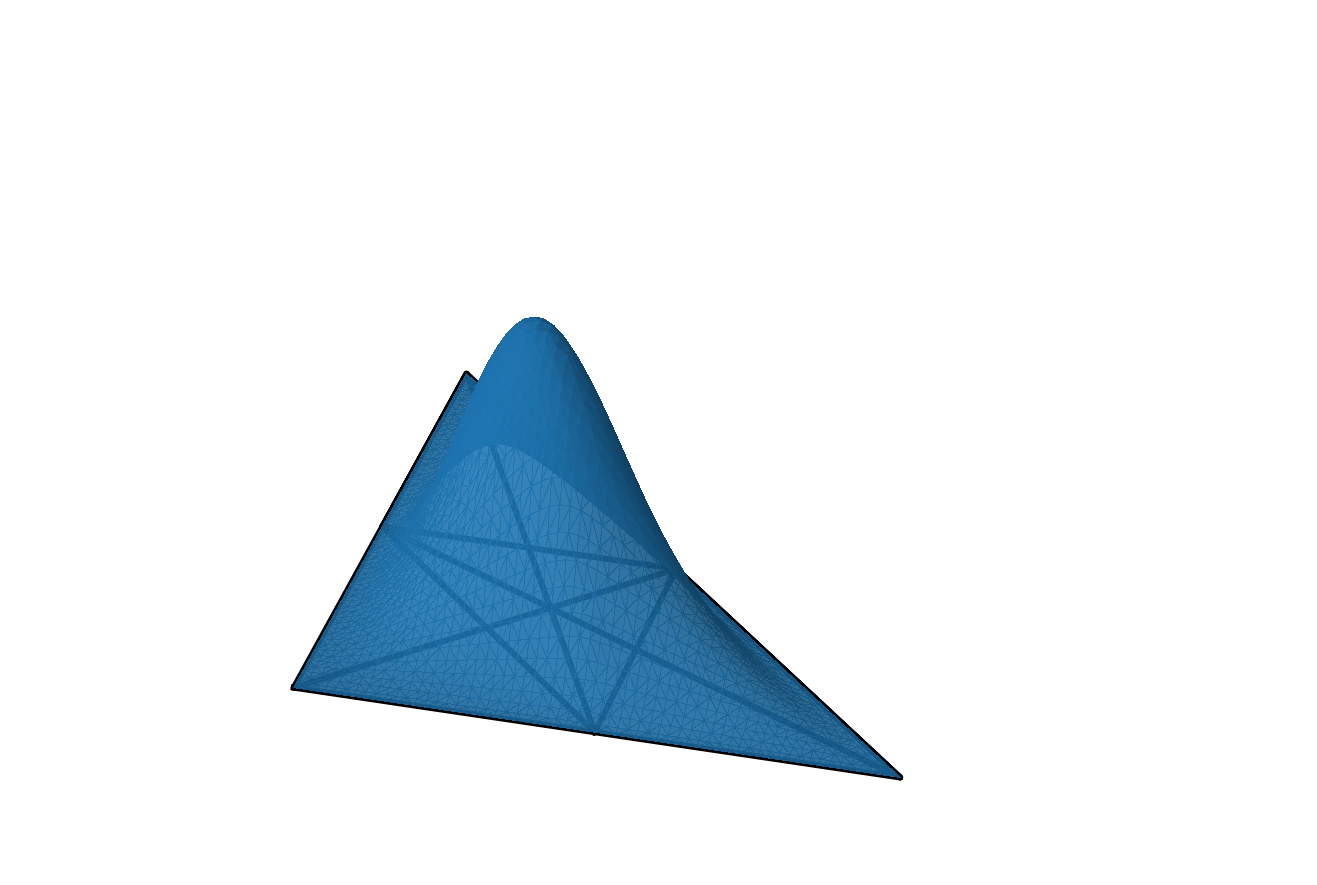

In [19]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = SSplines.ps12_vertices(triangle)
L = [p1, p2, p3, p1, p5, p6, p4, p5, p2, p6, p3, p4]

L_mm = [[2,0,0,1,0,1], [1,1,0,1,0,1], [1,1,1,1], [1,1,0,1,0,0,0,0,0,1], [1,1,1,0,0,0,0,0,0,1], \
        [1,1,0,0,1,1], [1,0,0,1,1,1], [1,0,0,1,0,1,0,0,0,1], [0,0,0,1,1,1,0,0,0,1], \
        [3,0,0,1,0,1], [2,1,0,1,0,1], [2,1,1,1], [1,1,0,1,1,1], [1,1,1,1,0,1], \
        [4,0,0,1,0,1], [3,1,0,1,0,1], [3,1,1,1], [2,2,2], [2,2,1,1], [2,1,1,1,0,1], [1,1,1,1,1,1]]

for mm in L_mm[-1:]:
    mm = mm + (10 - len(mm))*[0]
    print("We visualize Q"+str(mm)+":")
    s = SimplexSpline(triangle, mm)

    # the number of points correspond to the dimension of the bivariate polynomial space of degree 50. 
    points = SSplines.sample_triangle(triangle, 5*12)
    function_values = s(points)

    f = 3
    fig = plt.figure(figsize = (f*6,f*4))
    axs = Axes3D(fig)
    axs.set_axis_off()

    axs.view_init(52, 270 + 45/3)
    
    axs.plot3D([p[0] for p in L], [p[1] for p in L], len(L)*[0], linewidth = 2*f, color='black', zorder = -10)
    axs.plot_trisurf(points[:, 0], points[:, 1], function_values.astype('float'), antialiased=False, edgecolor='none', linewidth=0, alpha = 0.9, zorder = 10)
    bbox = transforms.Bbox([[f*1.15, f*0.4], [f*4.2, f*3.0]])
    fig.savefig(output_path + "ss-" + "".join([str(i) for i in mm]) + ".pdf", bbox_inches = bbox)
    plt.show()
    plt.close()

In [20]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = SSplines.ps12_vertices(triangle)
L = [p1, p2, p3, p1, p5, p6, p4, p5, p2, p6, p3, p4]

for degree in [1,2,3]:
    S = SSplines.SplineSpace(triangle, degree)
    for i in range(S.dimension):
        coefficients = S.dimension * [0]
        coefficients[i] = 1
        s = S.function(coefficients)
        points = SSplines.sample_triangle(triangle, 72)
        function_values = s(points)

        fig = plt.figure()
        axs = Axes3D(fig)
        axs.set_axis_off()

        axs.view_init(60, 270)

        axs.plot3D([p[0] for p in L], [p[1] for p in L], len(L)*[0], linewidth = 2, color='black', zorder = -10)
        axs.plot_trisurf(points[:, 0], points[:, 1], function_values, antialiased=True, edgecolor='none', linewidth=0, alpha = 0.9, zorder = 10)
        fig.savefig(output_path + "basis--degree-" + str(degree) + "-element-" + str(i) + ".png")
        plt.close()

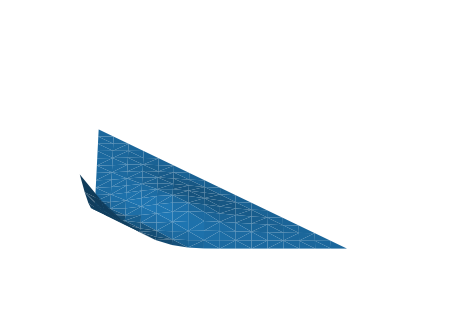

In [21]:
coefficients = np.array([1] + (S.dimension - 2)*[0] + [1])
s = S.function(coefficients)

points = SSplines.sample_triangle(triangle, 16)
function_values = s(points)

fig = plt.figure()
axs = Axes3D(fig)
axs.set_axis_off()

axs.view_init(60, 270)
axs.set_xlim(left=0.1, right=1)
axs.set_clip_on(True)
axs.set_clip_box(transforms.Bbox(np.array([[0.4, 0], [4, 1]])))
axs.plot_trisurf(points[:, 0], points[:, 1], function_values, antialiased=True, edgecolor='none', linewidth=0)

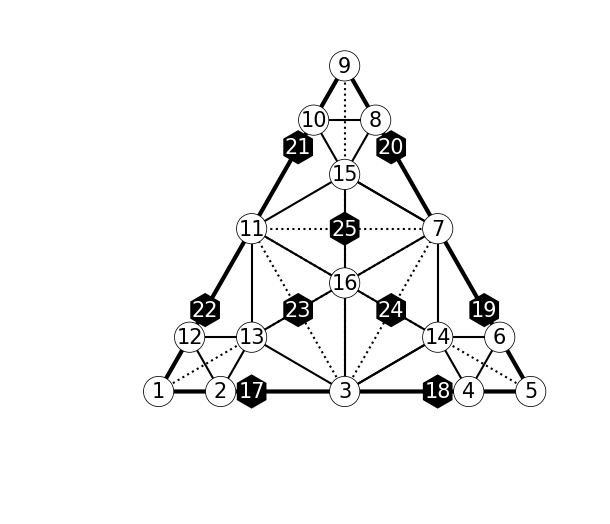

In [83]:
scale = 1
v1, v2, v3 = [(int(-12),int(0)), (int(12),int(0)), (int(0),int(21))]
Lv = ps12_vertices([v1, v2, v3])
v1, v2, v3, v4, v5, v6, v7, v8, v9, v10 = Lv

# Make a figure
fig = plt.figure(figsize = [2/scale, np.sqrt(3)/scale], dpi = 300)
ax = fig.add_subplot(1,1,1, frameon = True)

# Edges
x = [v4[0], v2[0], v3[0], v1[0], v4[0]]
y = [v4[1], v2[1], v3[1], v1[1], v4[1]]
line = matplotlib.lines.Line2D(x, y, lw = int(1), color='black', zorder = 2)
ax.add_line(line)
line = matplotlib.lines.Line2D([int(min(x) - 1), int(max(x) + 1)], \
                               [int(min(y) - 1), int(max(y) + 1)], \
                               lw = 0, color='white', zorder = 0)
ax.add_line(line)

# Interior edges
for i in range(6):
    for j in range(max(i,3),6):
        x = [Lv[i][0], Lv[j][0]]
        y = [Lv[i][1], Lv[j][1]]
        line = matplotlib.lines.Line2D(x, y, lw=0.5, color='black', zorder = 2, linestyle = ":")
        ax.add_line(line)

L = [bb[0]*v1 + bb[1]*v2 + bb[2]*v3 for bb in PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES[3-1]]
for i, xy in enumerate(L):
    x, y = xy
    #ax.add_artist(matplotlib.patches.RegularPolygon(xy, 6, radius = 0.95, color='black'))
    ax.add_artist(plt.Circle((x, y), radius = 1, facecolor = "black", zorder = 10))
    ax.add_artist(plt.Circle((x, y), radius = 0.95, facecolor = "white", zorder = 10))
    t = matplotlib.text.Text(x, y, str(i+1), zorder = 20, fontsize = 5/scale, \
                                ha='center', va='center', family='sans-serif', color='black')

    ax.add_artist(t)

domain_mesh_ind = [13, 12, 2, 13, 3, 14, 4, 6, 14, 7, 15, 8, 10, 15, 11, 13, 7, 15, 3, 14, 11]
for j in range(len(domain_mesh_ind)-1):
    i0 = domain_mesh_ind[j  ] - 1
    i1 = domain_mesh_ind[j+1] - 1
    x = [L[i0][0], L[i1][0]]
    y = [L[i0][1], L[i1][1]]
    line = matplotlib.lines.Line2D(x, y, lw=0.5, color='black', zorder = 2)
    ax.add_line(line)
    
    
L = [(v1+v4)/2, (v4+v2)/2, (v2+v5)/2, (v5+v3)/2, (v3+v6)/2, (v1+v6)/2, (v4+v6)/2, (v4+v5)/2, (v5+v6)/2]
for xy in L:
    i += 1
    x, y = xy
    ax.add_artist(matplotlib.patches.RegularPolygon(xy, 6, radius = 0.95, color='black'))
    #ax.add_artist(plt.Circle((x, y), radius = 1, facecolor = "black", zorder = 10))
    t = matplotlib.text.Text(x, y, str(i+1), zorder = 20, fontsize = 5/scale, \
                                ha='center', va='center', family='sans-serif', color='white')

    ax.add_artist(t)
    
plt.axis('equal')
plt.axis('off')

bbox = matplotlib.transforms.Bbox([[0.245,0.25], [1.8, 1.54]])
plt.savefig(output_path + "dual_point_averages.pdf", dpi = 300, bbox_inches = bbox)

plt.show()

plt.close('all')

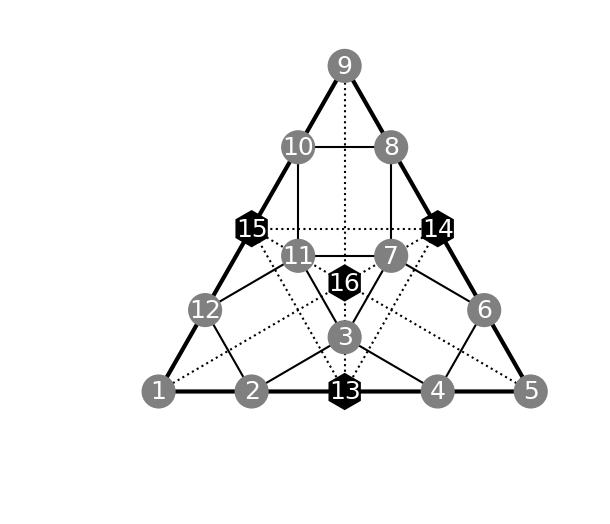

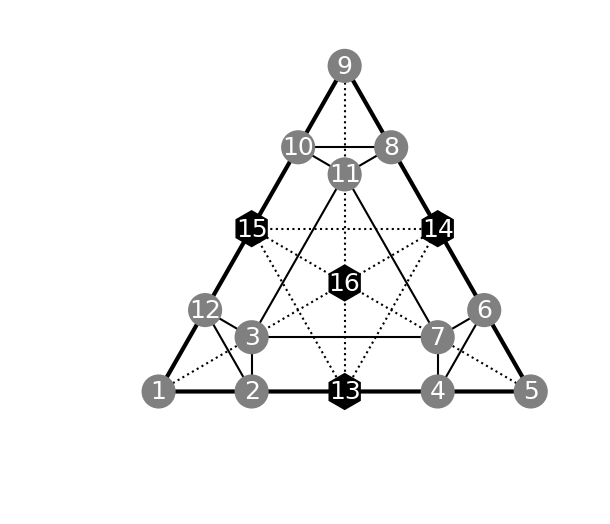

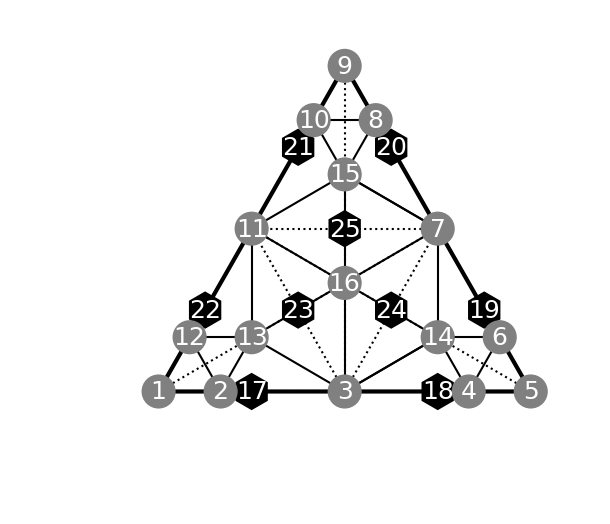

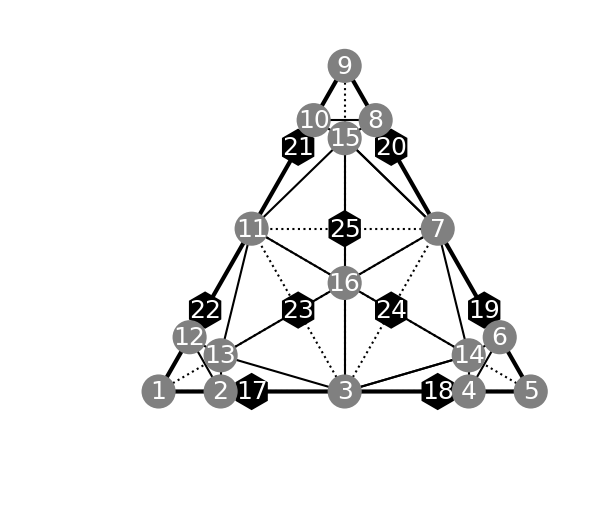

In [24]:
def draw_the_stuff(filename, triangle, L1, L2, domain_mesh_ind):
    scale = 1
    v1, v2, v3 = triangle
    Lv = ps12_vertices([v1, v2, v3])
    v1, v2, v3, v4, v5, v6, v7, v8, v9, v10 = Lv
    
    L1 = [bb[0]*v1 + bb[1]*v2 + bb[2]*v3 for bb in L1]
    L2 = [bb[0]*v1 + bb[1]*v2 + bb[2]*v3 for bb in L2]
    
    # Make a figure
    fig = plt.figure(figsize = [2/scale, np.sqrt(3)/scale], dpi = 300)
    ax = fig.add_subplot(1,1,1, frameon = True)

    # Edges
    x = [v4[0], v2[0], v3[0], v1[0], v4[0]]
    y = [v4[1], v2[1], v3[1], v1[1], v4[1]]
    line = matplotlib.lines.Line2D(x, y, lw = int(1), color='black', zorder = 2)
    ax.add_line(line)
    line = matplotlib.lines.Line2D([int(min(x) - 1), int(max(x) + 1)], \
                                   [int(min(y) - 1), int(max(y) + 1)], \
                                   lw = 0, color='white', zorder = 0)
    ax.add_line(line)

    # Interior edges
    for i in range(6):
        for j in range(max(i,3),6):
            x = [Lv[i][0], Lv[j][0]]
            y = [Lv[i][1], Lv[j][1]]
            line = matplotlib.lines.Line2D(x, y, lw=0.5, color='black', zorder = 2, linestyle = ":")
            ax.add_line(line)

    for i, xy in enumerate(L1):
        x, y = xy
        ax.add_artist(plt.Circle((x, y), radius = 1.1, facecolor = "gray", zorder = 10))
        t = matplotlib.text.Text(x, y, str(i+1), zorder = 20, fontsize = 6/scale, \
                                    ha='center', va='center', family='sans-serif', color='white')

        ax.add_artist(t)

    for j in range(len(domain_mesh_ind)-1):
        i0 = domain_mesh_ind[j  ] - 1
        i1 = domain_mesh_ind[j+1] - 1
        x = [L1[i0][0], L1[i1][0]]
        y = [L1[i0][1], L1[i1][1]]
        line = matplotlib.lines.Line2D(x, y, lw=0.5, color='black', zorder = 2)
        ax.add_line(line)

    for xy in L2:
        i += 1
        x, y = xy
        ax.add_artist(matplotlib.patches.RegularPolygon(xy, 6, radius = 1.05, color='black'))
        t = matplotlib.text.Text(x, y, str(i+1), zorder = 20, fontsize = 6/scale, \
                                    ha='center', va='center', family='sans-serif', color='white')

        ax.add_artist(t)

    plt.axis('equal')
    plt.axis('off')

    bbox = matplotlib.transforms.Bbox([[0.245,0.25], [1.8, 1.54]])
    plt.savefig(filename, dpi = 300, bbox_inches = bbox)

    plt.show()

    plt.close('all')

triangle = [(int(-12),int(0)), (int(12),int(0)), (int(0),int(21))]

L1 = PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES[2-1]
L2 = [(1/2,1/2,0), (0,1/2,1/2), (1/2,0,1/2), (1/3,1/3,1/3)]
domain_mesh_ind = [11,12,2,3,4,6,7,8,10,11,3,7,11]
draw_the_stuff(output_path + "dual_point_averages_quadratic.pdf", triangle, L1, L2, domain_mesh_ind)

L1 = PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_QUADRATIC_ALTERNATIVE
L2 = [(1/2,1/2,0), (0,1/2,1/2), (1/2,0,1/2), (1/3,1/3,1/3)]
domain_mesh_ind = [3,12,2,3,7,4,6,7,11,8,10,11,3]
draw_the_stuff(output_path + "dual_point_averages_quadratic_alternative.pdf", triangle, L1, L2, domain_mesh_ind)

L1 = PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES[3-1]
L2 = [(3/4, 1/4, 0), (1/4, 3/4, 0), (0, 3/4, 1/4), (0, 1/4, 3/4), \
      (1/4, 0, 3/4), (3/4, 0, 1/4), (1/2,1/4,1/4), (1/4,1/2,1/4), (1/4,1/4,1/2)]
domain_mesh_ind = [13, 12, 2, 13, 3, 14, 4, 6, 14, 7, 15, 8, 10, 15, 11, 13, 7, 15, 3, 14, 11]
    
draw_the_stuff(output_path + "dual_point_averages_cubic.pdf", triangle, L1, L2, domain_mesh_ind)

L1 = PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES_CUBIC_ALTERNATIVE
draw_the_stuff(output_path + "dual_point_averages_cubic_alternative.pdf", triangle, L1, L2, domain_mesh_ind)


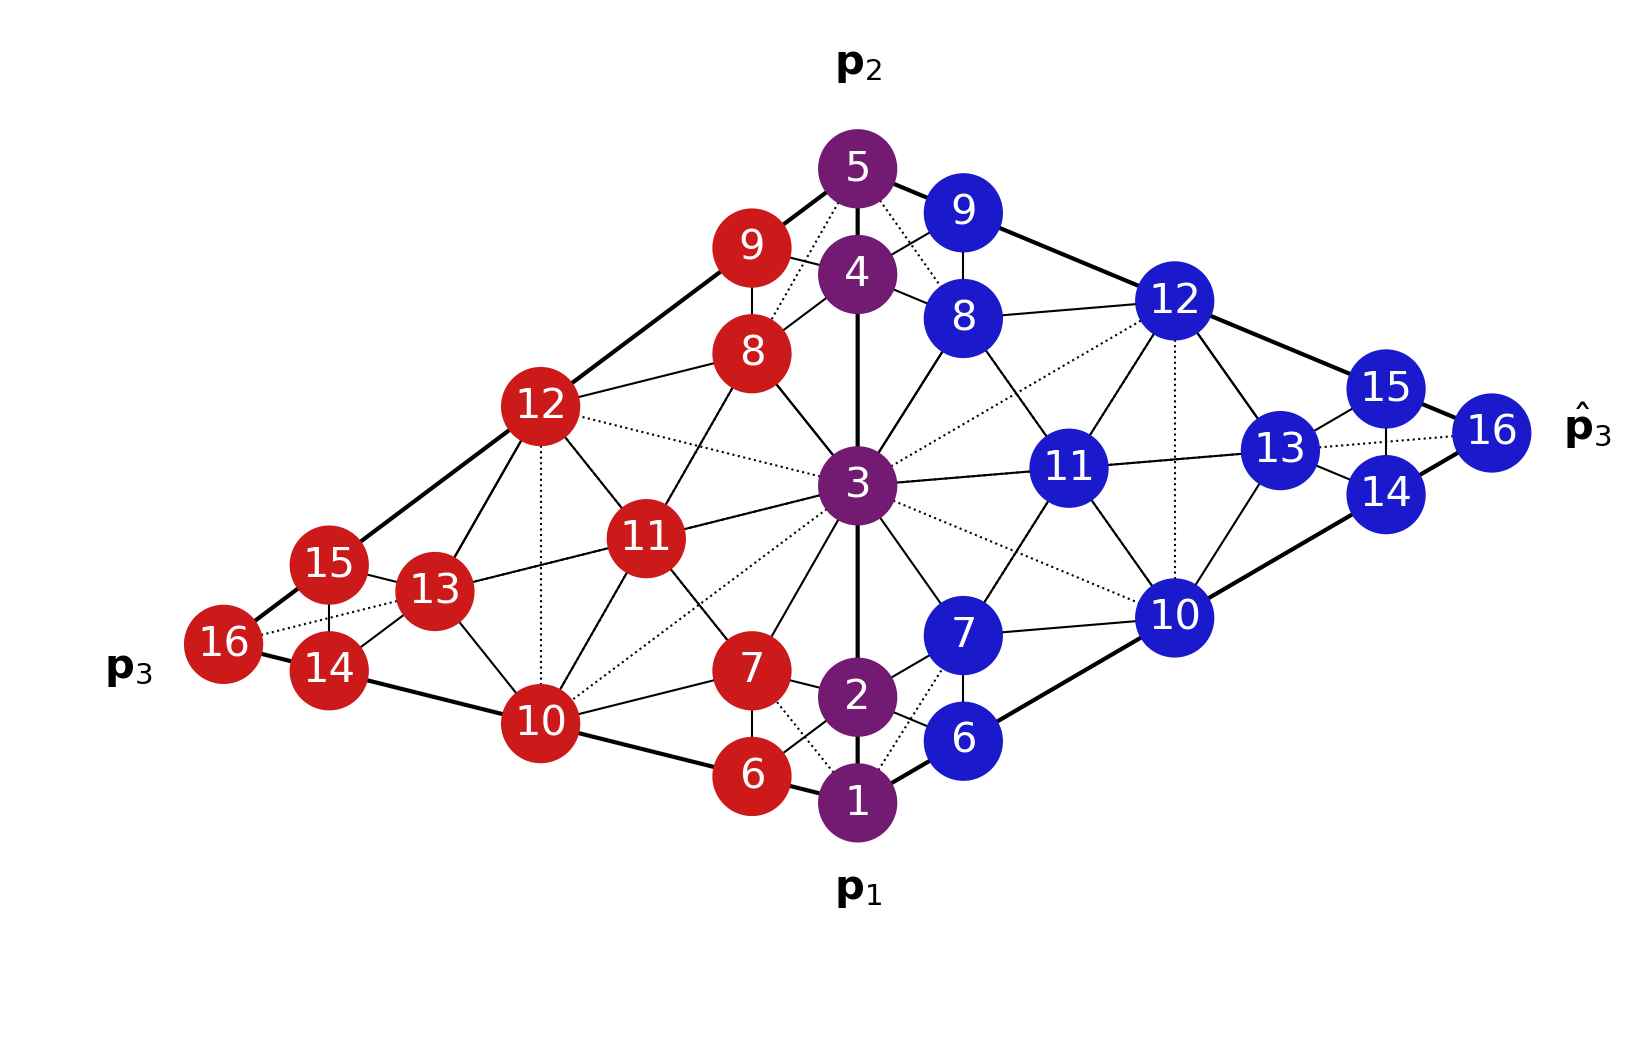

In [147]:
def draw_adjacent(filename, quadrilateral, L1, domain_mesh_ind):
    reordering = [1,2,3,4,5,12,13,14,6,11,16,7,15,10,8,9]

    scale = 1
    v1, v2, v3, w3 = quadrilateral
    
    Lv = ps12_vertices([v1, v2, v3])
    v1, v2, v3, v4, v5, v6, v7, v8, v9, v10 = Lv
    Lw = ps12_vertices([v1, v2, w3])
    w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 = Lw
    
    L1v = [bb[0]*v1 + bb[1]*v2 + bb[2]*v3 for bb in L1]
    L1w = [bb[0]*w1 + bb[1]*w2 + bb[2]*w3 for bb in L1]
    
    # Make a figure
    #fig = plt.figure(figsize = [2/scale, np.sqrt(3)/scale], dpi = 300)
    fig = plt.figure(dpi = 300)
    ax = fig.add_subplot(1,1,1)

    # Add vertex labels
    ax.text(*(1.15*v1 - 0.15*v2), "$\mathbf{p}_1$", fontsize = 10/scale, horizontalalignment='center')
    ax.text(*(1.15*v2 - 0.15*v1), "$\mathbf{p}_2$", fontsize = 10/scale, horizontalalignment='center')
    ax.text(*(1.15*v3 - 0.075*v1 - 0.075*v2), "$\mathbf{p}_3$", fontsize = 10/scale, horizontalalignment='center', verticalalignment='center')
    ax.text(*(1.15*w3 - 0.075*v1 - 0.075*v2), "$\hat{\mathbf{p}}_3$", fontsize = 10/scale, horizontalalignment='center', verticalalignment='center')
    
    # Edges
    x, y = zip(v1,v2,v3,v1,w3,v2)
    line = matplotlib.lines.Line2D(x, y, lw = int(1), color='black', zorder = 2)
    ax.add_line(line)
    #line = matplotlib.lines.Line2D([int(min(x) - 1), int(max(x) + 1)], \
    #                               [int(min(y) - 1), int(max(y) + 1)], \
    #                               lw = 0, color='white', zorder = 0)
    #ax.add_line(line)

    # Interior edges
    for i in range(6):
        for j in range(max(i,3),6):
            x, y = zip(Lv[i], Lv[j])
            ax.add_line(matplotlib.lines.Line2D(x, y, lw=0.5, color='black', zorder = 2, linestyle = ":"))

            x, y = zip(Lw[i], Lw[j])
            ax.add_line(matplotlib.lines.Line2D(x, y, lw=0.5, color='black', zorder = 2, linestyle = ":"))

    for i in range(5):
        x, y = L1v[i]
        ax.add_artist(plt.Circle((x, y), radius = 0.9, facecolor = (0.45,0.1,0.45), zorder = 10))
        t = matplotlib.text.Text(x, y, str(i+1), zorder = 20, fontsize = 10/scale, \
                                    ha='center', va='center', family='sans-serif', color='white')

        ax.add_artist(t)
    
    for i in range(5, 16):
        x, y = L1v[reordering[i]-1]
        ax.add_artist(plt.Circle((x, y), radius = 0.9, facecolor = (0.8,0.1,0.1), zorder = 10))
        t = matplotlib.text.Text(x, y, str(i+1), zorder = 20, fontsize = 10/scale, \
                                    ha='center', va='center', family='sans-serif', color='white')

        ax.add_artist(t)

        x, y = L1w[reordering[i]-1]
        ax.add_artist(plt.Circle((x, y), radius = 0.9, facecolor = (0.1,0.1,0.8), zorder = 10))
        t = matplotlib.text.Text(x, y, str(i+1), zorder = 20, fontsize = 10/scale, \
                                    ha='center', va='center', family='sans-serif', color='white')

        ax.add_artist(t)
        
    for j in range(len(domain_mesh_ind)-1):
        i0 = domain_mesh_ind[j  ] - 1
        i1 = domain_mesh_ind[j+1] - 1
        x, y = zip(L1v[i0],L1v[i1])
        line = matplotlib.lines.Line2D(x, y, lw=0.5, color='black', zorder = 2)
        ax.add_line(line)

    for j in range(len(domain_mesh_ind)-1):
        i0 = domain_mesh_ind[j  ] - 1
        i1 = domain_mesh_ind[j+1] - 1
        x, y = zip(L1w[i0],L1w[i1])
        line = matplotlib.lines.Line2D(x, y, lw=0.5, color='black', zorder = 2)
        ax.add_line(line)

    plt.axis('equal')
    plt.axis('off')
    
    #ax.set_aspect('equal')
    pad = 3
    eps = 0.5
    #bbox = matplotlib.transforms.Bbox([[-2.4 - eps, - eps], [2.4 + eps, 2.4 + eps]])
    #box = matplotlib.transforms.Bbox([[0.05, 0.0], [1.9, 1.85]])
    #bb = ax.get_window_extent()
    #h = bb.height/bb.width
    #plt.savefig(filename, bbox_inches = bbox)
    plt.savefig(filename, bbox_inches = 'tight')

    plt.show()

    plt.close('all')

quadrilateral = 0.6*np.array([(0,0),(0,24),(-24,6),(24,14)])
L1 = PS12_DOMAIN_POINTS_BARYCENTRIC_COORDINATES[3-1]
domain_mesh_ind = [13, 12, 2, 13, 3, 14, 4, 6, 14, 7, 15, 8, 10, 15, 11, 13, 7, 15, 3, 14, 11]
    
draw_adjacent(output_path + "adjacent_triangles.pdf", quadrilateral, L1, domain_mesh_ind)

In [119]:
print(my_bb.x0, my_bb.y0, my_bb.x1, my_bb.y1)

75.0 64.9519052838329 540.0 457.2614131981836
